<a href="https://www.kaggle.com/code/shishirkulal/cattle-breed-detection?scriptVersionId=286637964" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cattle-breeds-dataset/Cattle Breeds/Holstein Friesian cattle/HolsteinFriesiancattle61_c.jpg
/kaggle/input/cattle-breeds-dataset/Cattle Breeds/Holstein Friesian cattle/HolsteinFriesiancattle91_c.jpg
/kaggle/input/cattle-breeds-dataset/Cattle Breeds/Holstein Friesian cattle/HolsteinFriesiancattle140_c.jpg
/kaggle/input/cattle-breeds-dataset/Cattle Breeds/Holstein Friesian cattle/HolsteinFriesiancattle133_c.jpg
/kaggle/input/cattle-breeds-dataset/Cattle Breeds/Holstein Friesian cattle/HolsteinFriesiancattle137.jpg
/kaggle/input/cattle-breeds-dataset/Cattle Breeds/Holstein Friesian cattle/HolsteinFriesiancattle56.jpg
/kaggle/input/cattle-breeds-dataset/Cattle Breeds/Holstein Friesian cattle/HolsteinFriesiancattle28.jpg
/kaggle/input/cattle-breeds-dataset/Cattle Breeds/Holstein Friesian cattle/HolsteinFriesiancattle69.jpg
/kaggle/input/cattle-breeds-dataset/Cattle Breeds/Holstein Friesian cattle/HolsteinFriesiancattle52.jpg
/kaggle/input/cattle-breeds-dataset/Cattle Breeds/Hol

Loading and splitting data...
Detected 5 classes: ['Ayrshire cattle', 'Brown Swiss cattle', 'Holstein Friesian cattle', 'Jersey cattle', 'Red Dane cattle']
Train size: 966, Validation size: 242
Epoch 1/5
----------


train:   0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 1.3473 Acc: 0.5549


valid:   0%|          | 0/8 [00:00<?, ?it/s]

valid Loss: 1.1418 Acc: 0.7397
Epoch 2/5
----------


train:   0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.9267 Acc: 0.8002


valid:   0%|          | 0/8 [00:00<?, ?it/s]

valid Loss: 0.9247 Acc: 0.7769
Epoch 3/5
----------


train:   0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.7452 Acc: 0.8344


valid:   0%|          | 0/8 [00:00<?, ?it/s]

valid Loss: 0.7918 Acc: 0.8182
Epoch 4/5
----------


train:   0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.6368 Acc: 0.8571


valid:   0%|          | 0/8 [00:00<?, ?it/s]

valid Loss: 0.7455 Acc: 0.8388
Epoch 5/5
----------


train:   0%|          | 0/31 [00:00<?, ?it/s]

train Loss: 0.5449 Acc: 0.8820


valid:   0%|          | 0/8 [00:00<?, ?it/s]

valid Loss: 0.6838 Acc: 0.8182

Training complete in 0m 24s


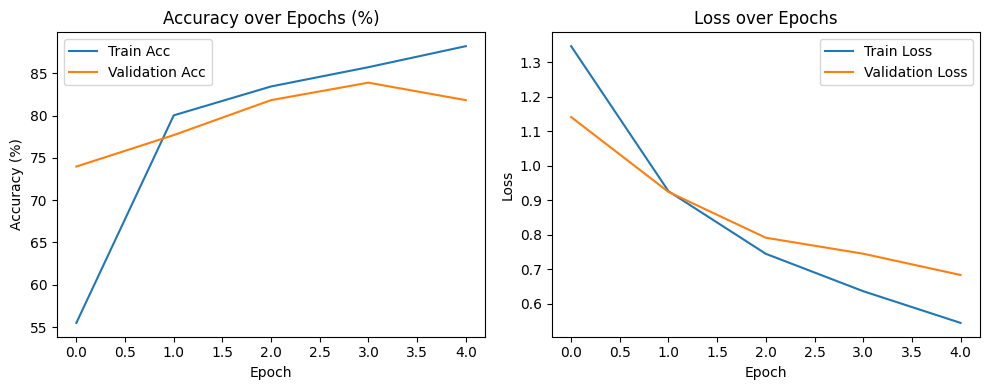


Final Validation Accuracy: 81.82%


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import time
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import numpy as np

# ----------------------------------------------------------------------
# 1. Configuration and Setup (MODIFIED FOR SINGLE-FOLDER DATASET)
# ----------------------------------------------------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- 🎯 CRITICAL PATH FIX: New single root path ---
# This path must point to the folder that DIRECTLY contains the breed folders.
data_dir = '../input/cattle-breeds-dataset/Cattle Breeds' 

num_epochs = 5 
BATCH_SIZE = 32
TRAIN_SPLIT_RATIO = 0.8 # 80% for training, 20% for validation
# ----------------------------------------------------------------------

# 2. Data Preprocessing and Loading (Transfer Learning Standard)
# ---
# Transformations for all images before splitting
full_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize all to standard CNN input size
    transforms.ToTensor(),
    # Standard normalization values for models pre-trained on ImageNet
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("Loading and splitting data...")
# Load ALL data from the single root directory
full_dataset = datasets.ImageFolder(data_dir, transform=full_transform)

# Determine sizes for the split
dataset_size = len(full_dataset)
train_size = int(TRAIN_SPLIT_RATIO * dataset_size)
valid_size = dataset_size - train_size

# Randomly split the dataset
train_dataset, valid_dataset = random_split(
    full_dataset, 
    [train_size, valid_size],
    generator=torch.Generator().manual_seed(42) # Use a seed for reproducibility
)

# Create DataLoaders for batching
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'valid': DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2) # No need to shuffle validation
}

dataset_sizes = {'train': train_size, 'valid': valid_size}
class_names = full_dataset.classes
num_classes = len(class_names)
data_splits = ['train', 'valid']

print(f"Detected {num_classes} classes: {class_names}")
print(f"Train size: {train_size}, Validation size: {valid_size}")


# 3. Model Setup: Transfer Learning with ResNet-50
# ---
model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze all the parameters in the network (Feature Extractor)
for param in model_ft.parameters():
    param.requires_grad = False

# Replace the last fully connected layer (Classifier Head)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

# 4. Define Loss Function and Optimizer
# ---
criterion = nn.CrossEntropyLoss()

# Only parameters of the final, new layer are being optimized
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)


# 5. Training Function
# ---
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    
    # Store training history
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in data_splits:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() 

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Record metrics
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['valid_loss'].append(epoch_loss)
                history['valid_acc'].append(epoch_acc.item())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    return model, history

# 6. Run the Training
# ---
model_final, history = train_model(model_ft, criterion, optimizer_ft, num_epochs=num_epochs)

# 7. Visualization
# ---
# Plotting the accuracy and loss curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(np.array(history['train_acc'])*100, label='Train Acc')
plt.plot(np.array(history['valid_acc'])*100, label='Validation Acc')
plt.title('Accuracy over Epochs (%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['valid_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nFinal Validation Accuracy: {history['valid_acc'][-1]*100:.2f}%")
